In [59]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, RandomRotation, RandomHorizontalFlip, RandomVerticalFlip, Compose, Normalize
from torch import nn
import matplotlib.pyplot as plt

## Loading Dataset

In [60]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([
        ToTensor(),
        RandomRotation(90),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        Normalize((0.5,), (0.5,))
    ])
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=Compose([
        ToTensor(),
        Normalize((0.5,), (0.5,))
    ])
)

train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

## Samples

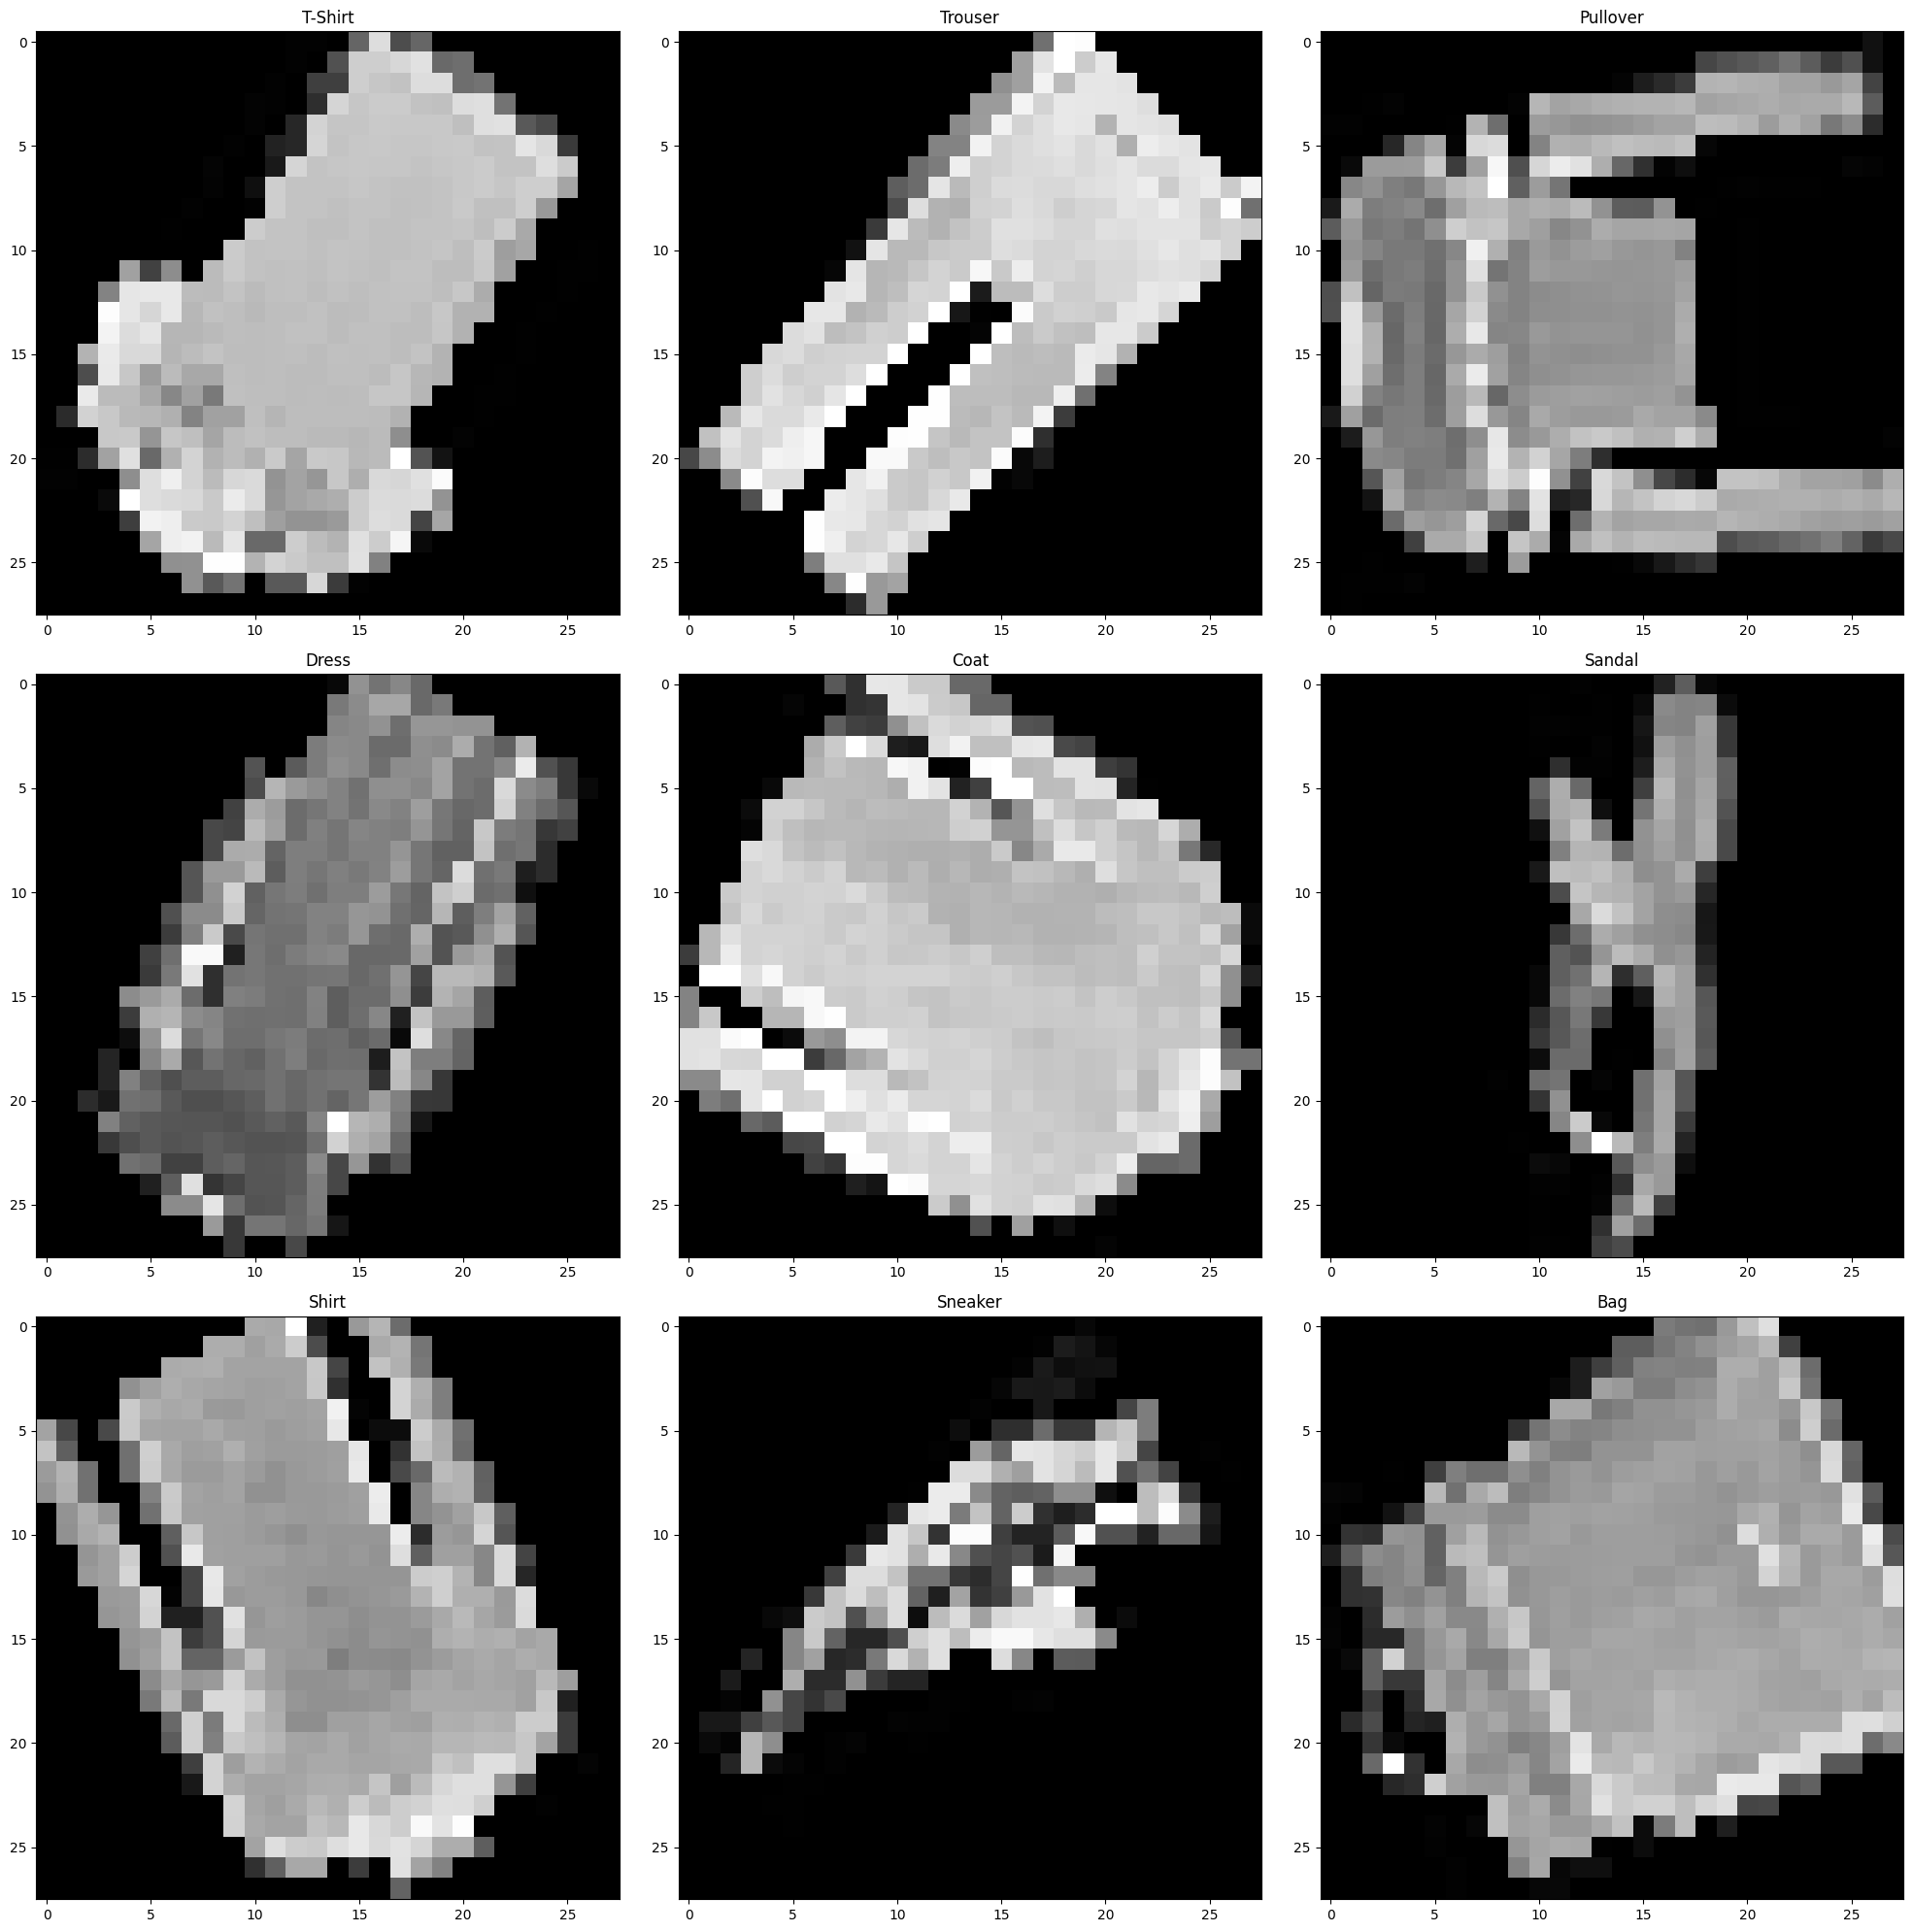

In [61]:
train_sample, train_label = next(iter(train_loader))

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

for ax, label in zip(axes.flatten(), labels_map.keys()):
    sample_idx = torch.where(train_label == label)[0][0].cpu().numpy()
    sample = train_sample[sample_idx]
    sample_title = labels_map[label]
    ax.set_title(sample_title)
    ax.imshow(sample.squeeze(), cmap='gray')

plt.tight_layout()
plt.show()

# Net

In [62]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        
        self.pool1 = nn.MaxPool2d(kernel_size=3)
        self.pool2 = nn.AvgPool2d(kernel_size=3)
        
        self.dropout = nn.Dropout(0.3)
        self.norm1 = nn.BatchNorm2d(128)
        self.norm2 = nn.BatchNorm2d(64)
        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64*2*2, 10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.dropout(x)
        x = self.norm1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout(x)
        x = self.norm2(x)
        
        x = self.flatten(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

## Training Model

In [63]:
from torch.optim import Adam

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Selected Device:', device)

EPOCHS = 40

torch.manual_seed(42)

model = ConvNet().to(device)
cost_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

def train(model, train_loader, optimizer, cost_func):
    total_loss = 0.0
    total_true_predicts = 0
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        pred = model(data)
        loss = cost_func(pred, target)
        total_loss += loss.item()
        pred_labels = torch.argmax(pred, dim=1)
        total_true_predicts += torch.sum(pred_labels == target)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    accuracy = total_true_predicts.item() / len(train_loader.dataset)
    loss = total_loss / len(train_loader)
    
    return loss, accuracy

def eval(model, test_loader, cost_func):
    total_loss = 0.0
    total_true_predicts = 0
    
    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        
        with torch.no_grad():
            pred = model(data)
            loss = cost_func(pred, target)
            
        total_loss += loss.item()
        pred_labels = torch.argmax(pred, dim=1)
        total_true_predicts += torch.sum(pred_labels == target)
    
    accuracy = total_true_predicts.item() / len(test_loader.dataset)
    loss = total_loss / len(test_loader)
    
    return loss, accuracy


min_loss = float('inf')
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, cost_function)
    val_loss, val_acc = eval(model, val_loader, cost_function)
    
    print(f'Epoch: {epoch+1}/{EPOCHS}... --> Train Loss: {train_loss:.6f}, Train Accuracy: {train_acc:.6f} | Val Loss: {val_loss:.6f}, Val Accuracy: {val_acc:.6f}')
    
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model, 'model.pt')

Selected Device: cuda:0
Epoch: 1/40... --> Train Loss: 2.013621, Train Accuracy: 0.460450 | Val Loss: 1.953427, Val Accuracy: 0.518700
Epoch: 2/40... --> Train Loss: 1.945651, Train Accuracy: 0.521817 | Val Loss: 1.917155, Val Accuracy: 0.550200
Epoch: 3/40... --> Train Loss: 1.907506, Train Accuracy: 0.558717 | Val Loss: 1.890266, Val Accuracy: 0.576800
Epoch: 4/40... --> Train Loss: 1.891889, Train Accuracy: 0.571717 | Val Loss: 1.861248, Val Accuracy: 0.599200
Epoch: 5/40... --> Train Loss: 1.885670, Train Accuracy: 0.576400 | Val Loss: 1.831617, Val Accuracy: 0.633000
Epoch: 6/40... --> Train Loss: 1.882175, Train Accuracy: 0.578383 | Val Loss: 1.854875, Val Accuracy: 0.612900
Epoch: 7/40... --> Train Loss: 1.876318, Train Accuracy: 0.583983 | Val Loss: 1.857138, Val Accuracy: 0.603600
Epoch: 8/40... --> Train Loss: 1.873709, Train Accuracy: 0.587000 | Val Loss: 1.839420, Val Accuracy: 0.619200
Epoch: 9/40... --> Train Loss: 1.871215, Train Accuracy: 0.589767 | Val Loss: 1.864233, 